In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load data
df = pd.read_csv("/Users/ruwaidaalharrasi/Desktop/AI/Credit Card Fraud/fraud test.csv")
df.drop(columns='Unnamed: 0', inplace=True, errors='ignore')

# Check for non-null values
print(df.isnull().sum())

# Check unique values per column
print(df.nunique())

# Check data types
df.dtypes

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
trans_date_trans_time    226976
cc_num                      904
merchant                    693
category                     14
amt                       37256
first                       341
last                        471
gender                        2
street                      924
city                        849
state                        50
zip                         912
lat      

trans_date_trans_time     object
cc_num                   float64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [3]:
# Convert datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d/%m/%Y %H:%M', errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], format='%d/%m/%Y', errors='coerce')

# Feature: Age
df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year

# Feature: Hour, Day of Week
df['hour'] = df['trans_date_trans_time'].dt.hour
df['dayofweek'] = df['trans_date_trans_time'].dt.dayofweek

# Feature: Suspicious travel (if distance > 300 km in less than 30 minutes)
df = df.sort_values(by=['cc_num', 'trans_date_trans_time'])
df['prev_time'] = df.groupby('cc_num')['trans_date_trans_time'].shift(1)
df['prev_lat'] = df.groupby('cc_num')['lat'].shift(1)
df['prev_long'] = df.groupby('cc_num')['long'].shift(1)

def check_suspicious(row):
    if pd.notna(row['prev_time']) and pd.notna(row['prev_lat']) and pd.notna(row['prev_long']):
        dist = geodesic((row['lat'], row['long']), (row['prev_lat'], row['prev_long'])).km
        time_diff = (row['trans_date_trans_time'] - row['prev_time']).total_seconds() / 60
        return 1 if dist > 300 and time_diff < 30 else 0
    return 0

df['suspicious_travel'] = df.apply(check_suspicious, axis=1)
df.drop(columns=['prev_lat', 'prev_long', 'prev_time', 'trans_date_trans_time', 'dob'], inplace=True)

# Define features and target
X = df.drop(columns=['is_fraud', 'first', 'last', 'trans_num', 'cc_num'], errors='ignore')
y = df['is_fraud']


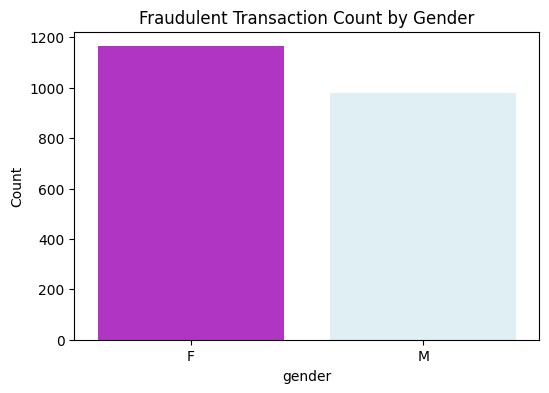

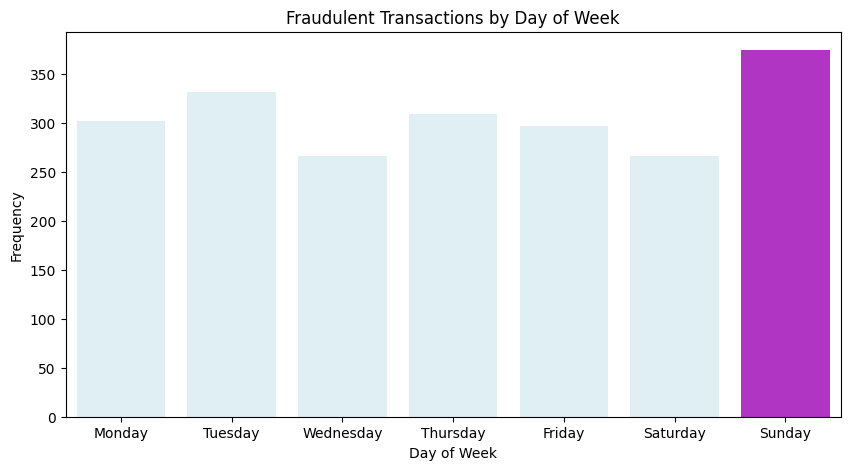

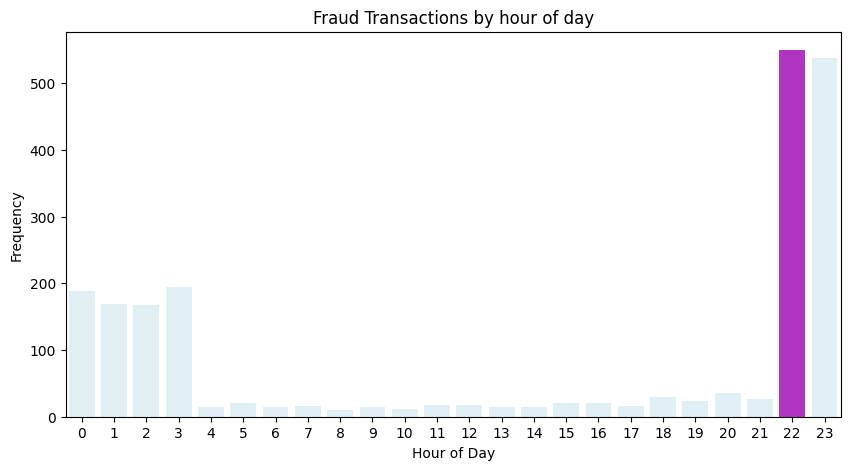

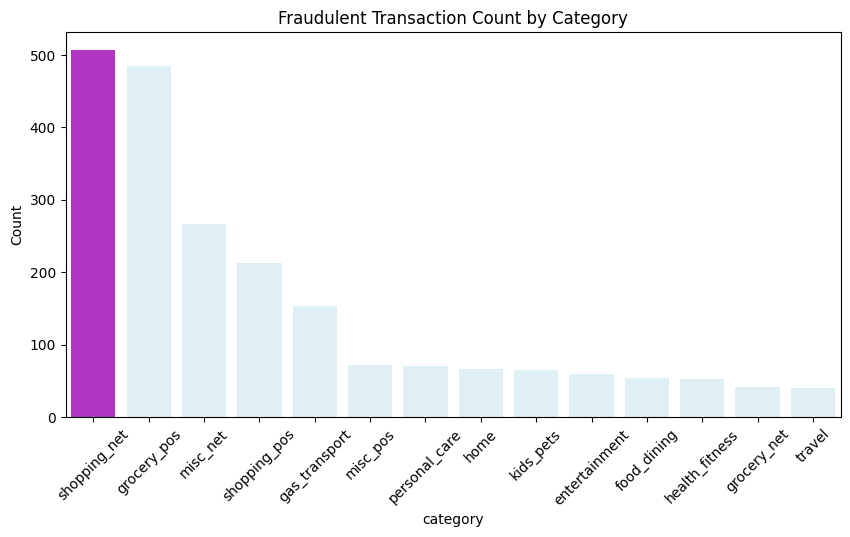

In [4]:
# Exploratory Data Analysis (EDA) - Visualizing Fraud Data by Different Features

# Filter only fraud transactions
df_fraud = df[df['is_fraud'] == 1]

# EDA - Gender (Fraud only)
plt.figure(figsize=(6, 4))
gender_counts = df_fraud['gender'].value_counts()
colors = ["#DDF0F7"] * len(gender_counts)
colors[np.argmax(gender_counts)] = "#C11DDA"
sns.barplot(x=gender_counts.index, y=gender_counts.values, palette=colors)
plt.title("Fraudulent Transaction Count by Gender")
plt.ylabel("Count")
plt.show()

# EDA - Day of Week (Fraud only)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 5))
day_counts = df_fraud['dayofweek'].value_counts().sort_index()
colors = ["#DDF0F7"] * len(day_counts)
colors[np.argmax(day_counts)] = '#C11DDA'
sns.barplot(x=day_names, y=day_counts.values, palette=colors)
plt.title("Fraudulent Transactions by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Frequency")
plt.show()

# EDA - Time (Fraud only)

plt.figure(figsize=(10, 5))
hour_counts = df_fraud['hour'].value_counts().sort_index()
colors = ["#DDF0F7"] * len(hour_counts)
colors[np.argmax(hour_counts)] = '#C11DDA'
sns.barplot(x=hour_counts.index, y=hour_counts.values, palette=colors)
plt.title("Fraud Transactions by hour of day")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.show()

# EDA - Category (Fraud only)
plt.figure(figsize=(10, 5))
category_counts = df_fraud['category'].value_counts()
colors = ["#DDF0F7"] * len(category_counts)
colors[np.argmax(category_counts)] = '#C11DDA'
sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors)
plt.title("Fraudulent Transaction Count by Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Key Insights from EDA

- **Fraud Occurrences Peak on Sundays:**  
  The highest number of fraud cases happen on Sundays, suggesting that weekends may be more vulnerable to fraudulent activities.

- **Fraud is More Frequent During Late Night Hours:**  
  There is a noticeable spike in fraud cases between 10 PM and 3 AM, indicating that fraud tends to occur mostly during nighttime hours.

- **'Shopping net' Category is Highly Associated with Fraud:**  
  The 'Shopping net' transaction category shows a higher count of fraudulent cases, suggesting it could be a strong predictor for fraud detection.



Random Forest Evaluation
              precision    recall  f1-score   support

           0      0.998     1.000     0.999    221432
           1      0.927     0.551     0.692       856

    accuracy                          0.998    222288
   macro avg      0.963     0.776     0.845    222288
weighted avg      0.998     0.998     0.998    222288

ROC-AUC: 0.9823797275330702


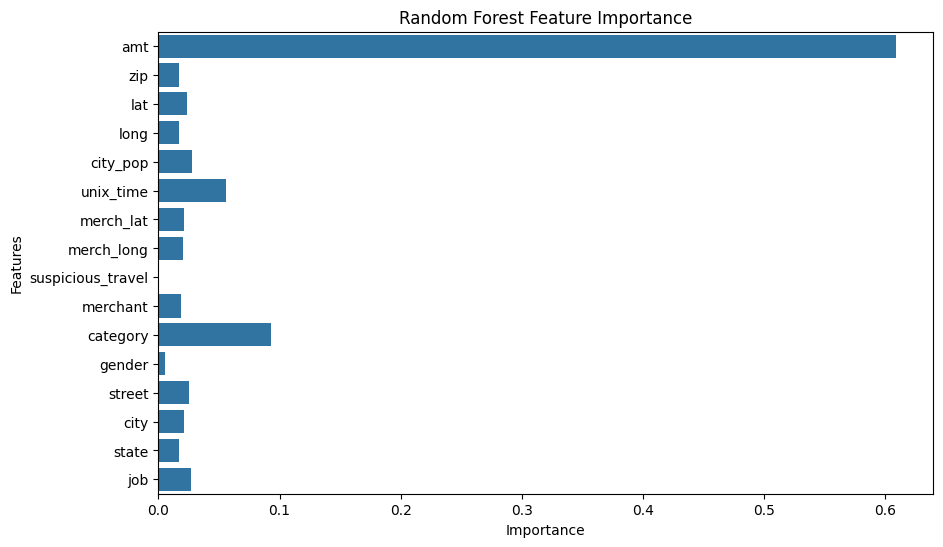


XGBoost Evaluation
              precision    recall  f1-score   support

           0      0.999     1.000     0.999    221432
           1      0.927     0.751     0.830       856

    accuracy                          0.999    222288
   macro avg      0.963     0.875     0.915    222288
weighted avg      0.999     0.999     0.999    222288

ROC-AUC: 0.9986556731367584


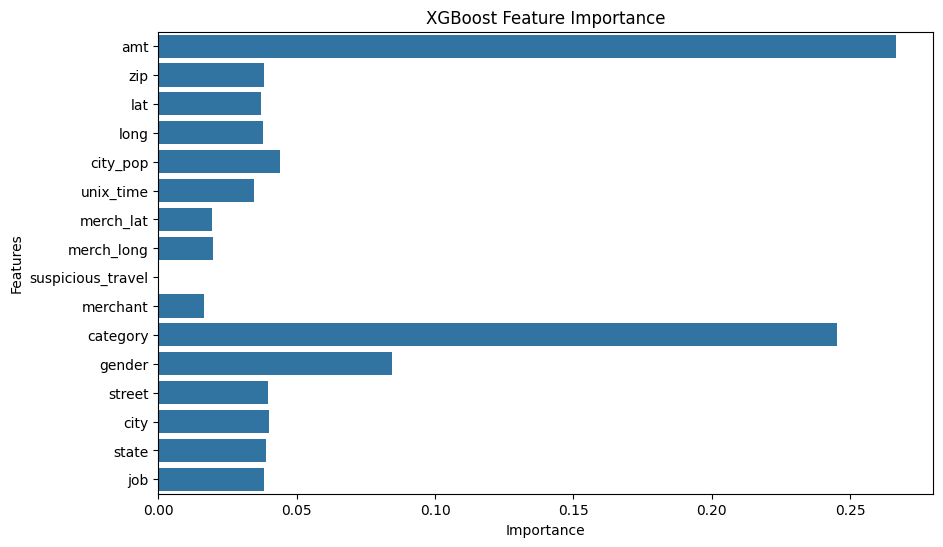

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing pipelines
handle_numerical = Pipeline(steps=[
    ('impute_numerical', SimpleImputer(strategy='mean'))
])

handle_categorical = Pipeline(steps=[
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('encode_cat', OrdinalEncoder())
])

preprocessing = ColumnTransformer(transformers=[
    ('numerical', handle_numerical, numerical_cols),
    ('categorical', handle_categorical, categorical_cols)
])

# Random Forest Pipeline
rf_model = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# XGBoost Pipeline
xgb_model = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Fit and evaluate Random Forest
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print("\nRandom Forest Evaluation")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


# Feature Importance - RF
rf_features = numerical_cols + categorical_cols
importances_rf = rf_model.named_steps['classifier'].feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=importances_rf, y=rf_features)
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Fit and evaluate XGBoost
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("\nXGBoost Evaluation")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


# Feature Importance - XGB
xgb_features = numerical_cols + categorical_cols
importances_xgb = xgb_model.named_steps['classifier'].feature_importances_

plt.figure(figsize=(10,6))
sns.barplot(x=importances_xgb, y=xgb_features)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



# Key Insights on Model Performance

- **Random Forest:**
  - Achieves very high overall accuracy (99.8%) with excellent precision and recall for the non-fraud class.
  - For the fraud class (minority class), precision is high (92.7%) but recall is moderate (55.1%), indicating it misses nearly half of fraud cases.
  - The ROC-AUC score is strong at 0.982, showing good overall discrimination ability.
  - F1-score for fraud class is 0.692, reflecting the trade-off between precision and recall.

- **XGBoost:**
  - Slightly better overall accuracy (99.9%) compared to Random Forest.
  - Maintains similarly high precision for fraud (92.7%) but improves recall significantly to 75.1%, detecting more fraud cases.
  - ROC-AUC is excellent at 0.999, indicating near-perfect classification performance.
  - F1-score for fraud is higher at 0.830, showing better balance between precision and recall.

**Overall:**  
XGBoost outperforms Random Forest in detecting fraud, especially by improving recall, which is critical for catching more fraudulent transactions while maintaining high precision.


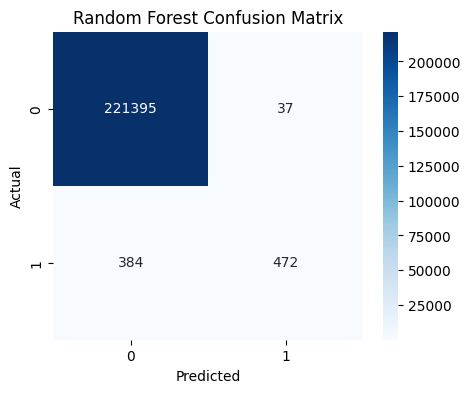

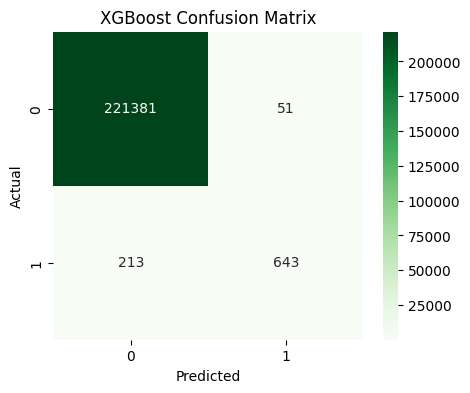

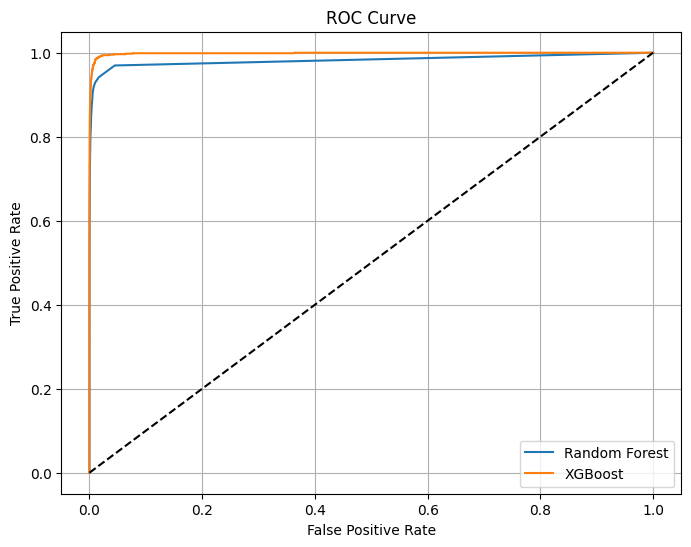

In [6]:
# Confusion Matrix - RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Confusion Matrix - XGB
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()